# Computer Vision

In [41]:
from typing import Any

from sklearn.metrics import classification_report

# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from torchmetrics import F1Score
from torchmetrics.classification import MulticlassROC

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Importing The Data

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [4]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [7]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_data.data[0].shape

torch.Size([28, 28])

In [9]:
# official documentation uses this.
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

Check this [link](https://pytorch.org/tutorials/intermediate/memory_format_tutorial.html) for info on how to change the image format to suit best practices.

In [10]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

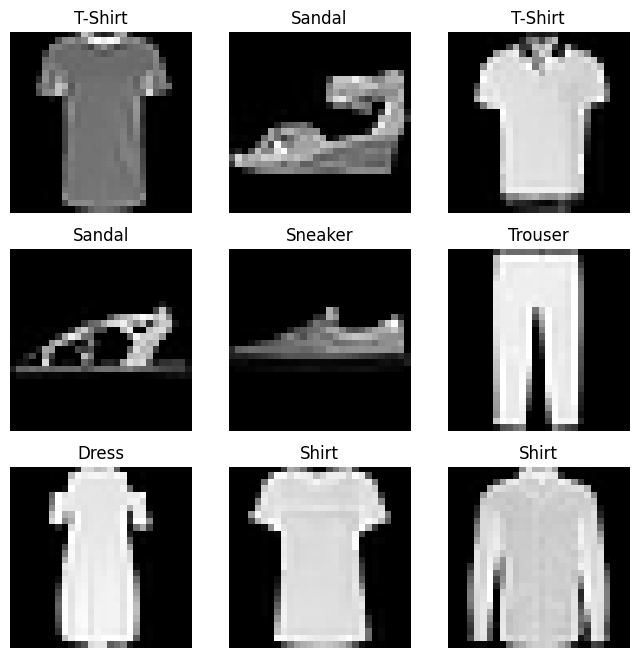

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”(memory), reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoaders does this for us! :)

In [12]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)


In [13]:
len(train_dataloader) # * 32 = 60000

1875

In [14]:
len(train_dataloader.dataset)

60000

In [15]:
len(train_dataloader.dataset[0]) # tuple -> (X,y)

2

In [16]:
train_dataloader.dataset[0][0].shape

torch.Size([1, 28, 28])

## Building Models

In this notebook, we will build 2 different models.

### BoilerPlate Class

This class has the training and testing loops, which are the same for all models.
The methods common to all models are: 
- train_loop, where we compute one training epoch. It may include several training steps, in case of batch training.
- testing_loop, where we compute one testing epoch. Again, it may include several test steps. Usually this loop receives validation data.
- train_model: method which goes through each epoch, and trains the model.
- predict: method to compute model predictions.

In [66]:
class BoilerPlate(nn.Module):
    def __init__(self):
        super().__init__()
        self.train_loss_values = []
        self.test_loss_values = []
        self.f1_macro = F1Score(task="multiclass", num_classes= len(labels_map),
                          average="macro")
        self.f1_micro = F1Score(task="multiclass", num_classes= len(labels_map),
                          average="micro")

    def train_loop(self, dataloader: DataLoader, loss_fn:nn.modules.loss._Loss, 
                   optimizer: torch.optim.Optimizer) -> tuple[Any,Any,Any]:
        size = len(dataloader.dataset) # type: ignore
        num_batches = len(dataloader)
        self.train()
        train_loss,f1_macro, f1_micro = 0,0,0
        for batch, (input, labels) in enumerate(dataloader):
            input, labels = input.to(device), labels.to(device)
            # CrossEntropyLoss works directly with logits as inputs
            logits = self(input)
            # CrossEntropyLoss expects a tensor of type long as targets.
            # if we don't do the type casting outside the loss function, we get an error
            labels_long = labels.to(dtype=torch.long)
            loss = loss_fn(logits, labels_long)
            # we'll add the loss accross batches/steps, and in the end average them.
            # and for this, we need a new variable like train_loss to avoid  
            # RuntimeError:Trying to backward through the graph a second time
            train_loss += loss
            # return rows with prob like quantities of size 6
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1) 
            f1_macro += self.f1_macro(pred, labels)
            f1_micro += self.f1_micro(pred, labels)  
            # also equal to self.f1(nn.Softmax(dim=1)(logits), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # uncomment below for printing losses during batch training
            # if batch % 100 == 0:
            # loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        train_loss /= num_batches
        f1_macro /= f1_macro # I'm not sure about the implications of avg over f1 score...
        f1_micro /= f1_micro
        return train_loss, f1_macro, f1_micro
    
    def test_loop(self, dataloader:DataLoader, 
                  loss_fn:nn.modules.loss._Loss) -> tuple[Any,Any,Any]:
        num_batches = len(dataloader)
        self.eval()
        with torch.inference_mode():
            test_loss,f1_macro, f1_micro = 0,0,0
            for batch, (input, labels) in enumerate(dataloader):
                input, labels = input.to(device), labels.to(device)
                logits = self(input)
                labels_long = labels.to(dtype=torch.long)
                loss = loss_fn(logits, labels_long)
                test_loss += loss
                pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
                f1_macro += self.f1_macro(pred, labels)
                f1_micro += self.f1_micro(pred, labels)
            test_loss /= num_batches
            f1_macro /= f1_macro
            f1_micro /= f1_micro 
        return test_loss, f1_macro, f1_micro
    
    def train_model(self, dataloader:DataLoader, loss_fn:nn.modules.loss._Loss, 
                    optimizer: torch.optim.Optimizer, n_epochs:int = 100) -> None:
        for epoch in tqdm(range(1,n_epochs+1)):
            print(f"\nEpoch {epoch}\n-------------------------------")
            train_loss, train_f1_macro, train_f1_micro = self.train_loop(
                dataloader = dataloader, loss_fn = loss_fn, optimizer = optimizer
            )
            self.train_loss_values.append(train_loss.detach().cpu().numpy())
            test_loss, test_f1_macro, test_f1_micro = self.test_loop(
                dataloader = dataloader, loss_fn = loss_fn
            )
            self.test_loss_values.append(test_loss.detach().cpu().numpy())
            print(
                f"{loss_fn._get_name()} Train Loss: {train_loss} |"
                f"{loss_fn._get_name()} Test Loss: {test_loss}"
            )
            print(
                f"F1 Train Score (macro,micro): {train_f1_macro,train_f1_micro}  |"
                f"F1 Test Score (macro,micro): {test_f1_macro,test_f1_micro}"
            )
        print("Done!")
    
    def predict(self, input: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.inference_mode():
            logits = self(input.to(device=device, dtype=torch.float32))
            pred = nn.Softmax(dim=1)(logits).argmax(dim=1)
        return pred
    
    def evaluation_report(self, input: torch.Tensor, labels: torch.Tensor,
                          labels_names: list[str]):
        pred = self.predict(input)
        print(classification_report(y_pred = pred.cpu().numpy(), y_true = labels.cpu().numpy(),
                              target_names = labels_names))

### Linear Model

In [67]:
class LinearModel(BoilerPlate):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # inputs must be in vector shape
            nn.Linear(in_features=input_shape, out_features=hidden_units), 
            # in_features = 28*28 (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [68]:
input_shape = 28*28
hidden_units = 512
output_shape = len(labels_map)
learning_rate = 1e-3
n_epochs = 5
lin_model = LinearModel(input_shape = input_shape,hidden_units = hidden_units,
                        output_shape = output_shape).to(device)
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params = lin_model.parameters(), lr = learning_rate)

In [69]:
lin_model(train_dataloader.dataset[0][0].to(device))

tensor([[ 0.0201,  0.2125, -0.0384, -0.0888,  0.0334,  0.2394,  0.2307,  0.1191,
          0.0427, -0.2472]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [70]:
lin_model.train_model(train_dataloader, loss_fn= loss_fn, 
                      optimizer= optimizer, n_epochs = n_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------


 20%|██        | 1/5 [00:14<00:58, 14.54s/it]

CrossEntropyLoss Train Loss: 1.5892634391784668 |CrossEntropyLoss Test Loss: 1.1626641750335693
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 2
-------------------------------


 40%|████      | 2/5 [00:29<00:43, 14.63s/it]

CrossEntropyLoss Train Loss: 1.006898045539856 |CrossEntropyLoss Test Loss: 0.8999126553535461
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 3
-------------------------------


 60%|██████    | 3/5 [00:43<00:29, 14.59s/it]

CrossEntropyLoss Train Loss: 0.8410616517066956 |CrossEntropyLoss Test Loss: 0.7932235598564148
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 4
-------------------------------


 80%|████████  | 4/5 [00:58<00:14, 14.54s/it]

CrossEntropyLoss Train Loss: 0.7598467469215393 |CrossEntropyLoss Test Loss: 0.730582058429718
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 5
-------------------------------


100%|██████████| 5/5 [01:12<00:00, 14.54s/it]

CrossEntropyLoss Train Loss: 0.7076278924942017 |CrossEntropyLoss Test Loss: 0.687047004699707
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Done!


In [71]:
lin_model.predict(test_data.data)

tensor([9, 2, 1,  ..., 8, 1, 7], device='cuda:0')

### Convolutional Model

In [109]:
# Create a convolutional neural network 
class TinyVGG(BoilerPlate):
    """
    Model architecture copying TinyVGG from: 
    https://www.learnpytorch.io/03_pytorch_computer_vision/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            # input shape of Conv2d is (number of samples, in_channels, height, width)
            # ouput shape of Conv2d is (number of samples, out_channels, out_height, out_width)
            # out_heigh, and out_width will be determined by kernel_size, stride, and padding
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same 
                      # shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [117]:
input_shape = 1 # number of channels. In our case we just have 1, greyscale.
hidden_units = 20
output_shape = len(labels_map)
learning_rate = 1e-3
n_epochs = 5
# convolutional model
conv_model = TinyVGG(input_shape = input_shape,hidden_units = hidden_units,
                        output_shape = output_shape).to(device)
conv_loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
conv_optimizer = torch.optim.SGD(params = conv_model.parameters(), lr = learning_rate)

In [118]:
next(iter(train_dataloader))[0].to(device).shape

torch.Size([32, 1, 28, 28])

In [119]:
train_dataloader.dataset[0][0].unsqueeze(dim=0).shape

torch.Size([1, 1, 28, 28])

In [120]:
conv_model(train_dataloader.dataset[0][0].unsqueeze(dim=0).to(device))

tensor([[ 0.0147, -0.0478,  0.0272,  0.0727, -0.0528,  0.0496, -0.0112, -0.0024,
         -0.0400,  0.0387]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [121]:
conv_model.train_model(train_dataloader, loss_fn= conv_loss_fn, 
                      optimizer= conv_optimizer, n_epochs = n_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------


 20%|██        | 1/5 [00:16<01:04, 16.07s/it]

CrossEntropyLoss Train Loss: 2.2907774448394775 |CrossEntropyLoss Test Loss: 2.257558584213257
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 2
-------------------------------


 40%|████      | 2/5 [00:31<00:47, 15.86s/it]

CrossEntropyLoss Train Loss: 1.3829972743988037 |CrossEntropyLoss Test Loss: 0.7953259944915771
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 3
-------------------------------


 60%|██████    | 3/5 [00:47<00:31, 15.75s/it]

CrossEntropyLoss Train Loss: 0.7626288533210754 |CrossEntropyLoss Test Loss: 0.7405754923820496
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 4
-------------------------------


 80%|████████  | 4/5 [01:03<00:15, 15.69s/it]

CrossEntropyLoss Train Loss: 0.697597861289978 |CrossEntropyLoss Test Loss: 0.728380560874939
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Epoch 5
-------------------------------


100%|██████████| 5/5 [01:18<00:00, 15.77s/it]

CrossEntropyLoss Train Loss: 0.6491590142250061 |CrossEntropyLoss Test Loss: 0.6342823505401611
F1 Train Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))  |F1 Test Score (macro,micro): (tensor(1., device='cuda:0'), tensor(1., device='cuda:0'))
Done!


## Model Evaluation

In [ ]:
lin_model.evaluation_report(input = test_data.data,
                            labels = test_data.targets,
                            labels_names = list(labels_map.values())
                            )

              precision    recall  f1-score   support

     T-Shirt       0.73      0.78      0.75      1000
     Trouser       0.97      0.92      0.94      1000
    Pullover       0.69      0.57      0.62      1000
       Dress       0.75      0.83      0.79      1000
        Coat       0.54      0.81      0.65      1000
      Sandal       0.99      0.42      0.59      1000
       Shirt       0.47      0.23      0.31      1000
     Sneaker       0.69      0.88      0.78      1000
         Bag       0.87      0.93      0.90      1000
  Ankle Boot       0.73      0.94      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.71     10000
weighted avg       0.74      0.73      0.71     10000



In [123]:
conv_model.evaluation_report(input = test_data.data.unsqueeze(dim=1),
                            labels = test_data.targets,
                            labels_names = list(labels_map.values()))

              precision    recall  f1-score   support

     T-Shirt       0.73      0.78      0.75      1000
     Trouser       0.87      0.91      0.89      1000
    Pullover       0.78      0.38      0.51      1000
       Dress       0.79      0.78      0.78      1000
        Coat       0.50      0.86      0.63      1000
      Sandal       1.00      0.33      0.49      1000
       Shirt       0.33      0.20      0.25      1000
     Sneaker       0.71      0.84      0.77      1000
         Bag       0.87      0.96      0.91      1000
  Ankle Boot       0.66      0.98      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.68     10000
weighted avg       0.72      0.70      0.68     10000



Our results differ from the pytorch tutorial. 
All of them are lower than in the tutorial. Some reasons could be:
- Using the whole test dataset, instead of doing averages per epoch.
- Using Scikit-learn accuracy function, instead of PyTorch's.
Another difference is also the inverted performance relation. Our linear model is better than
the convolution.
- I'm using many more hidden units (512) for the linear model.